In [1]:
from glob import glob
import cv2
from matplotlib import pyplot as plt
%matplotlib ipympl

ball_frame_gt_files = glob('ball_frames/*GT.png')
ball_frame_files = [f for f in glob('ball_frames/*.png') if f not in ball_frame_gt_files]

ball_frame_gt_files.sort(key=lambda x: int(x.split('/')[-1].split('_')[0].split(".")[0].split("-")[1]))
ball_frame_files.sort(key=lambda x: int(x.split('/')[-1].split('_')[0].split(".")[0].split("-")[1]))

print(ball_frame_files)
print(ball_frame_gt_files)
print(len(ball_frame_files), len(ball_frame_gt_files))


['ball_frames/frame-54.png', 'ball_frames/frame-55.png', 'ball_frames/frame-56.png', 'ball_frames/frame-57.png', 'ball_frames/frame-58.png', 'ball_frames/frame-59.png', 'ball_frames/frame-60.png', 'ball_frames/frame-61.png', 'ball_frames/frame-62.png', 'ball_frames/frame-63.png', 'ball_frames/frame-64.png', 'ball_frames/frame-65.png', 'ball_frames/frame-66.png', 'ball_frames/frame-67.png', 'ball_frames/frame-68.png', 'ball_frames/frame-69.png', 'ball_frames/frame-70.png', 'ball_frames/frame-71.png', 'ball_frames/frame-72.png', 'ball_frames/frame-73.png', 'ball_frames/frame-74.png', 'ball_frames/frame-75.png', 'ball_frames/frame-76.png', 'ball_frames/frame-77.png', 'ball_frames/frame-78.png', 'ball_frames/frame-79.png', 'ball_frames/frame-80.png', 'ball_frames/frame-81.png', 'ball_frames/frame-82.png', 'ball_frames/frame-83.png', 'ball_frames/frame-84.png', 'ball_frames/frame-85.png', 'ball_frames/frame-86.png', 'ball_frames/frame-87.png', 'ball_frames/frame-88.png', 'ball_frames/frame-

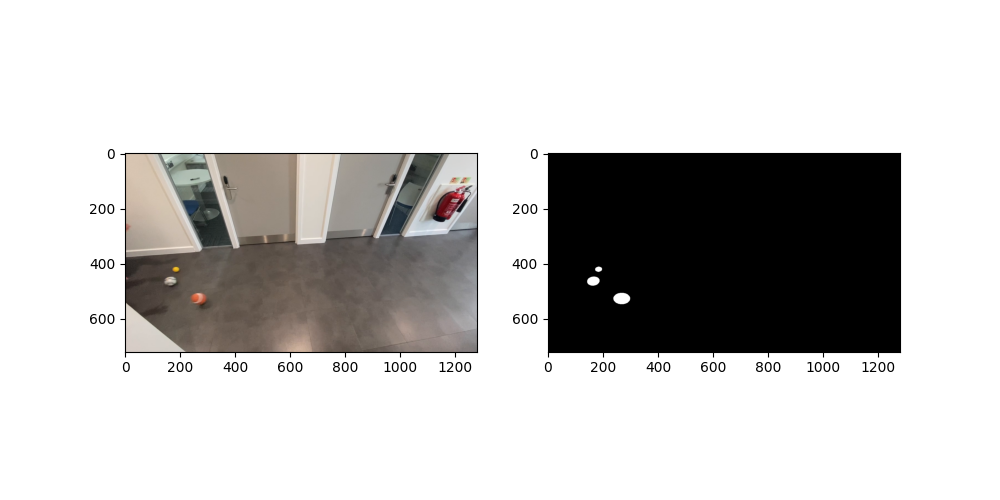

In [2]:
sample_idx = 4
img = cv2.imread(ball_frame_files[sample_idx])
img_gt = cv2.imread(ball_frame_gt_files[sample_idx])

plt.rcParams['figure.figsize'] = [10, 5]
# plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB))

In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.data import coins
from skimage.transform import rescale

from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image

def run_kmean(smoothened_img, n_regions = 25):

    graph = image.img_to_graph(smoothened_img)

    # Take a decreasing function of the gradient: an exponential
    # The smaller beta is, the more independent the segmentation is of the
    # actual image. For beta=1, the segmentation is close to a voronoi
    beta = 10
    eps = 1e-6
    graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

    
    n_regions_plus = 3
    assign_labels = "kmeans"
    print('Processing', assign_labels)
    t0 = time.time()
    labels = spectral_clustering(
        graph,
        n_clusters=(n_regions + n_regions_plus),
        eigen_tol=1e-7,
        assign_labels=assign_labels,
        random_state=42,
    )

    t1 = time.time()
    labels = labels.reshape(smoothened_img.shape)

    return labels, n_regions

def plot_contours(labels, n_regions, rescaled_img):
    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_img, cmap=plt.cm.gray)

    plt.xticks(())
    plt.yticks(())
    title = f"Spectral clustering: {assign_labels}"
    print(title)
    plt.title(title)
    for l in range(n_regions):
        colors = [plt.cm.nipy_spectral((l + 4) / float(n_regions + 4))]
        plt.contour(labels == l, colors=colors)
        # To view individual segments as appear comment in plt.pause(0.5)
    plt.show()


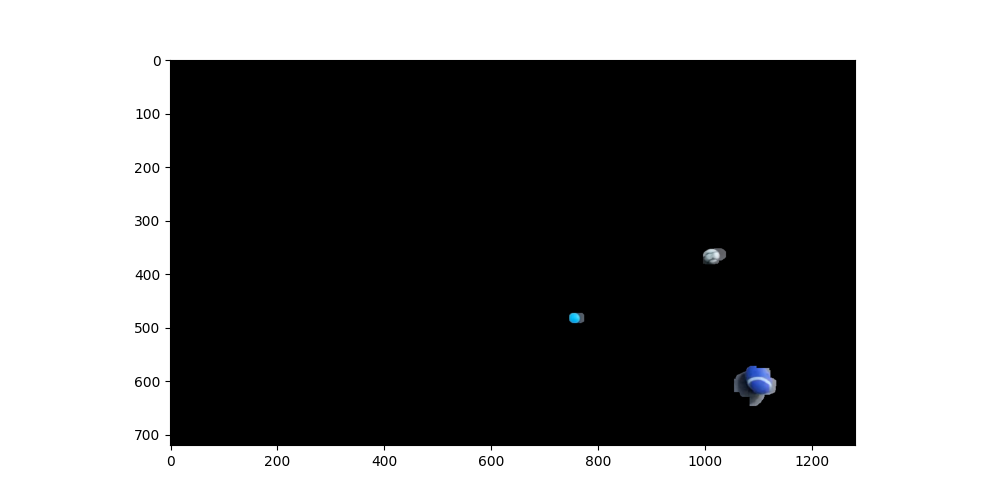

In [4]:
img1 = cv2.imread(ball_frame_files[50])
img2 = cv2.imread(ball_frame_files[51])

diff_img = cv2.absdiff(img1, img2)
diff_gray_img = cv2.cvtColor(diff_img, cv2.COLOR_BGR2GRAY)

plt.figure()
# plt.imshow(diff_gray_img, cmap='gray')


kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(diff_gray_img, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=20)
mask = closing > 30
mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=5)
mask = (mask > 0).astype(np.uint8)

result = cv2.bitwise_and(img1,img1, mask= mask)

plt.imshow(result)

# smoothened_img = gaussian_filter(diff_gray_img, sigma=2)
# rescaled_img = rescale(smoothened_img, 0.1, mode="reflect", anti_aliasing=False)

# labels, n_regions = run_kmean(rescaled_img)
# plot_contours(labels, n_regions, rescaled_img)

# ret,thresh1 = cv2.threshold(diff_img,100,255,cv2.THRESH_BINARY)

# plt.imshow(thresh1, cmap='gray')

[[[ 22 220 233]]]


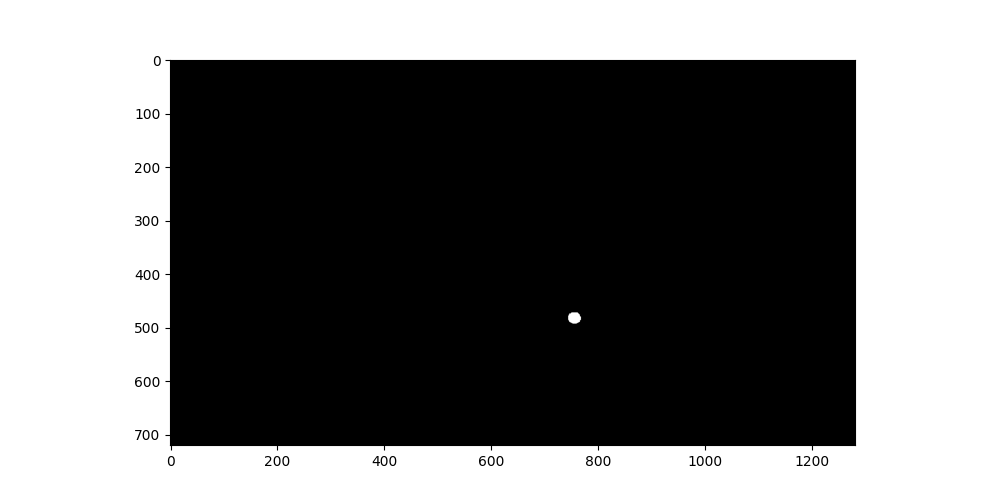

In [5]:
# color threshold
yellow_ball_color = [233,178,32]
yellow_ball_hsv = [22, 220, 233]
yellow_ball_hsv_low = np.array([15, 100, 100])
yellow_ball_hsv_high = np.array([30, 256, 256])


img1 = cv2.imread(ball_frame_files[50])
yellow_img = np.zeros([1,1,3], dtype=np.uint8)
yellow_img[0,0] = yellow_ball_color
print(cv2.cvtColor(yellow_img, cv2.COLOR_RGB2HSV))

hsv_img = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)


frame_threshold = cv2.inRange(hsv_img, yellow_ball_hsv_low, yellow_ball_hsv_high)

# de-noise
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
opened = cv2.morphologyEx(frame_threshold, cv2.MORPH_OPEN, kernel)

# Close the wholes
closed = cv2.morphologyEx(frame_threshold, cv2.MORPH_CLOSE, kernel)

# Find the biggest connected component
connectivity = 4 
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(closed, connectivity, cv2.CV_32S)

sizes = stats[:, -1]

max_label = 1
max_size = sizes[1]
for i in range(2, nb_components):
    if sizes[i] > max_size:
        max_label = i
        max_size = sizes[i]
img2 = np.zeros(output.shape)
img2[output == max_label] = 255

plt.figure()
plt.imshow(img2, cmap='gray')


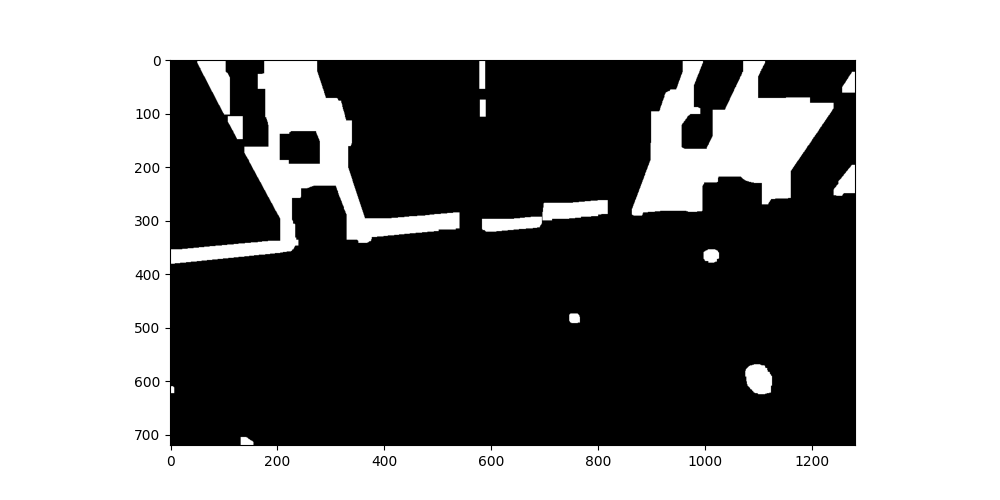

In [27]:
img1 = cv2.imread(ball_frame_files[50])
edges = cv2.Canny(img1,100,200)
kernel = np.ones((3,3),np.uint8)

# img1 = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
# img1 = cv2.morphologyEx(img1, cv2.MORPH_OPEN, kernel)
img1 = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=20)
img1 = cv2.morphologyEx(img1, cv2.MORPH_OPEN, kernel, iterations=5)
# contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# result = cv2.drawContours(img1, contours, -1, (0,255,0), -1)

plt.figure()
plt.imshow(img1, cmap='gray')